<p><b>Commercial banks</b> receive <u><b><em>a lot</em></b></u> of applications for credit cards. Many of them get rejected for many reasons, like high loan balances, low income levels, or too many inquiries on an individual's credit report, for example. Manually analyzing these applications is mundane, error-prone, and time-consuming (and time is money!). Luckily, this task can be automated with the power of machine learning and pretty much every commercial bank does so nowadays. In this notebook, I will build an automatic credit card approval predictor using machine learning techniques, just like the real banks do.</p>
<p><img src="https://image.freepik.com/free-photo/hand-showing-credit-card-mock-up_23-2148304916.jpg" alt="Credit card being held in hand width="600" height="300"></p>

I'll use the <a href="http://archive.ics.uci.edu/ml/datasets/credit+approval">Credit Card Approval dataset</a> from the UCI Machine Learning Repository. The structure of this notebook is as follows:

<ul>
<li>First, I will start off by loading and viewing the dataset.</li>
<li>I will see that the dataset has a mixture of both numerical and non-numerical features, that it contains values from different ranges, plus that it contains a number of missing entries.</li>
<li>I will preprocess the dataset to ensure the machine learning model I choose can make good predictions.</li>
<li>After the data is in good shape, I will do some exploratory data analysis to build intuitions.</li>
<li>Finally, I will build a machine learning model that can predict if an individual's application for a credit card will be accepted.</li>
</ul>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline

In [3]:
cc_apps = pd.read_csv("datasets/cc_approvals.data", header=None)
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


## Inspecting the applications
<p>The features of this dataset have been anonymized to protect the privacy, but <a href="http://rstudio-pubs-static.s3.amazonaws.com/73039_9946de135c0a49daa7a0a9eda4a67a72.html">this blog</a> gives a pretty good overview of the probable features. The probable features in a typical credit card application are <code>Gender</code>, <code>Age</code>, <code>Debt</code>, <code>Married</code>, <code>BankCustomer</code>, <code>EducationLevel</code>, <code>Ethnicity</code>, <code>YearsEmployed</code>, <code>PriorDefault</code>, <code>Employed</code>, <code>CreditScore</code>, <code>DriversLicense</code>, <code>Citizen</code>, <code>ZipCode</code>, <code>Income</code> and finally the <code>ApprovalStatus</code>. This gives a pretty good starting point, and we can map these features with respect to the columns in the output.   </p>
<p>As we can see from our first glance at the data, the dataset has a mixture of numerical and non-numerical features. This can be fixed with some preprocessing, but before we do that, let's learn about the dataset a bit more to see if there are other dataset issues that need to be fixed.</p>

In [4]:
print(cc_apps.describe(), '\n')
print(cc_apps.info(), '\n')
unq = []
for col in cc_apps:
    print(cc_apps[col].unique(), '\n')

               2           7          10             14
count  690.000000  690.000000  690.00000     690.000000
mean     4.758725    2.223406    2.40000    1017.385507
std      4.978163    3.346513    4.86294    5210.102598
min      0.000000    0.000000    0.00000       0.000000
25%      1.000000    0.165000    0.00000       0.000000
50%      2.750000    1.000000    0.00000       5.000000
75%      7.207500    2.625000    3.00000     395.500000
max     28.000000   28.500000   67.00000  100000.000000 

&lt;class &#39;pandas.core.frame.DataFrame&#39;&gt;
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       690 non-null    object 
 1   1       690 non-null    object 
 2   2       690 non-null    float64
 3   3       690 non-null    object 
 4   4       690 non-null    object 
 5   5       690 non-null    object 
 6   6       690 non-null    object 
 7   7       690 non-null    float64
 8   

## Handling the missing values (part I)
<p>We've uncovered some issues that will affect the performance of our machine learning model(s) if they go unchanged:</p>
<ul>
<li>Our dataset contains both numeric and non-numeric data (specifically data that are of <code>float64</code>, <code>int64</code> and <code>object</code> types). Specifically, the features <code>2</code>, <code>7</code>, <code>10</code> and <code>14</code> contain numeric values (of types float64, float64, int64 and int64 respectively) and all the other features contain non-numeric values.</li>
<li>The dataset also contains values from several ranges. Some features have a value range of 0 - 28, some have a range of 2 - 67, and some have a range of 1017 - 100000. Apart from these, we can get useful statistical information (like <code>mean</code>, <code>max</code>, and <code>min</code>) about the features that have numerical values. </li>
<li>Finally, the dataset has missing values, which we'll take care of below. The missing values in the dataset are labeled with '?', which can be seen in the last cell's output.</li>
</ul>

In [5]:
cc_apps = cc_apps.replace('?',np.nan)

<p>We replaced all the question marks with NaNs. This is going to help us with imputing the missing values with a strategy called mean imputation.</p>

In [6]:
cc_apps.fillna(cc_apps.mean(), inplace=True)
cc_apps.isna().sum()

0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64

## Handling the missing values (part II)
<p>We have successfully taken care of the missing values present in the numeric columns. There are still some missing values to be imputed for columns 0, 1, 3, 4, 5, 6 and 13. All of these columns contain non-numeric data and this why the mean imputation strategy would not work here. This needs a different treatment. </p>
<p>We are going to impute these missing values with the most frequent values as present in the respective columns.</p>

In [7]:
for col in np.array(cc_apps.columns):
    if cc_apps[col].dtype == 'object':
        cc_apps = cc_apps.fillna(cc_apps[col].value_counts().index[0])
cc_apps.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

## Preprocessing the data
<p>The missing values are now successfully handled.</p>
<p>There is still some minor but essential data preprocessing needed before we proceed towards building the machine learning model. I am going to divide these remaining preprocessing steps into three main tasks:</p>
<ol>
<li>Convert the non-numeric data into numeric.</li>
<li>Split the data into train and test sets. </li>
<li>Scale the feature values to a uniform range.</li>
</ol>

### Task 1.

In [8]:
le = LabelEncoder()
for col in cc_apps:
    if cc_apps[col].dtype=='object':
        cc_apps[col]=le.fit_transform(cc_apps[col])
cc_apps.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,156,0.000,2,1,13,8,1.25,1,1,1,0,0,68,0,0
1,0,328,4.460,2,1,11,4,3.04,1,1,6,0,0,11,560,0
2,0,89,0.500,2,1,11,4,1.50,1,0,0,0,0,96,824,0
3,1,125,1.540,2,1,13,8,3.75,1,1,5,1,0,31,3,0
4,1,43,5.625,2,1,13,8,1.71,1,0,0,0,2,37,0,0


### Task 2.
<p>The data has been converted successfully </p>
<p>Now, we will split the data into train set and test set to prepare our data for two different phases of machine learning modeling: training and testing. Ideally, no information from the test data should be used to scale the training data or should be used to direct the training process of a machine learning model. Hence, we first split the data and then apply the scaling.</p>
<p>Also, features like <code>DriversLicense</code> and <code>ZipCode</code> are not as important as the other features in the dataset for predicting credit card approvals. I will drop them to design the machine learning model with the best set of features. </p>

In [9]:
cc_apps = cc_apps.drop([11, 13], axis=1)
cc_apps = cc_apps.values

X, y = cc_apps[:,0:13], cc_apps[:,13]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Task 3
<p>The data is now split into two separate sets - train and test sets respectively. We are only left with one final preprocessing step of scaling before we can fit a machine learning model to the data. </p>

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
# we use (0, 1) because the class atribute is binary
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

## Fitting a logistic regression model to the train set
<p><a href="http://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.names">According to UCI</a>, our dataset contains more instances that correspond to "Denied" status than instances corresponding to "Approved" status. Specifically, out of 690 instances, there are 383 (55.5%) applications that got denied and 307 (44.5%) applications that got approved. </p>
<p><em>Are the features that affect the credit card approval decision process correlated with each other?</em> Although I have visualised correlation below, I will ignore it and assume that they indeed are strongly correlated. </p>

&lt;matplotlib.axes._subplots.AxesSubplot at 0x1ccb129ad00&gt;

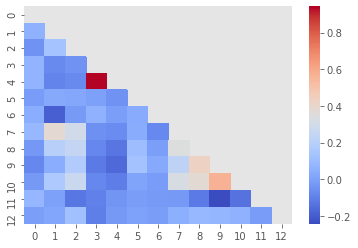

In [11]:
matrix = np.triu(pd.DataFrame(X).corr())
sns.heatmap(pd.DataFrame(X).corr(), mask=matrix, cmap='coolwarm')

<p><b>Because of this correlation</b>, we'll take advantage of the fact that generalized linear models perform well in these cases. Let's start our machine learning modeling with a Logistic Regression.</p>

In [12]:
logreg = LogisticRegression()
logreg.fit(rescaledX_train, y_train)

LogisticRegression()

## Making predictions and evaluating performance
<p>But how well does the model perform? </p>
<p>We will now evaluate our model on the test set with respect to classification accuracy. But we will also take a look the model's confusion matrix. In the case of predicting credit card applications, it is equally important to see if our machine learning model is able to predict the approval status of the applications as denied that originally got denied. If our model is not performing well in this aspect, then it might end up approving the application that should have been approved. The confusion matrix helps us to view our model's performance from these aspects.  </p>

In [13]:
y_pred = logreg.predict(rescaledX_test)
print("Accuracy of logistic regression classifier: ", logreg.score(rescaledX_test, y_test))
confusion_matrix(y_test, y_pred)

Accuracy of logistic regression classifier:  0.8405797101449275


array([[87, 10],
       [23, 87]], dtype=int64)

## Grid searching and making the model perform better
<p>The model was pretty good! It was able to yield an accuracy score of almost 84%.</p>
<p>For the confusion matrix, the first element of the first row of the confusion matrix denotes the true negatives meaning the number of negative instances (denied applications) predicted by the model correctly. And the last element of the second row of the confusion matrix denotes the true positives meaning the number of positive instances (approved applications) predicted by the model correctly.</p>
<p>Let's see if we can do better. We can perform a grid search of the model parameters to improve the model's ability to predict credit card approvals.</p>
<p>scikit-learn's implementation of logistic regression consists of different hyperparameters but we will grid search over the following three:</p>
<ul>
<li>tol</li>
<li>max_iter</li>
<li>penalty</li>
</ul>

In [14]:
tol = [0.01, 0.001, 0.0001]
max_iter = [100, 150, 200]
penalty = ['l1', 'l2', 'elasticnet']

# Create a dictionary where tol, max_iter and panelty are keys and the lists of their values are corresponding values
param_grid = dict(tol=tol, max_iter=max_iter, penalty=penalty)

## Finding the best performing model
<p>Instead of passing train and test sets separately, I will supply <code>X</code> (scaled version) and <code>y</code>. I will also instruct <code>GridSearchCV()</code> to perform a cross-validation of five folds.</p>
<p>We'll end the section by storing the best-achieved score and the respective best parameters, ploting ROC Curve and calculating AUC for both optimized and default models.</p>

In [15]:
grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
rescaledX = scaler.fit_transform(X)
grid_model_result = grid_model.fit(rescaledX, y)

best_score, best_params = grid_model_result.best_score_, grid_model_result.best_params_
print("Best: %f using %s" % (best_score, best_params))

Best: 0.850725 using {&#39;max_iter&#39;: 100, &#39;penalty&#39;: &#39;l2&#39;, &#39;tol&#39;: 0.01}


===========AUC============
sliced data default AUC: 0.7050609184629804
full data optimized AUC: 0.7112933458294283


&lt;matplotlib.legend.Legend at 0x1ccb34c1c10&gt;

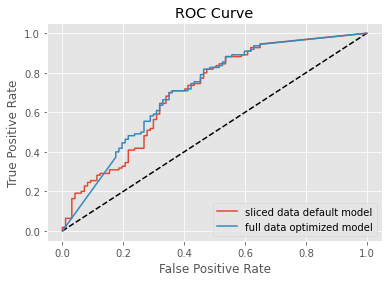

In [16]:
# Compute predicted probabilities
sliced_data_model_y_prob = logreg.predict_proba(X_test)[:,1]
full_data_model_y_prob = grid_model.predict_proba(X_test)[:,1]

sliced_fpr, sliced_tpr, _ = roc_curve(y_test, sliced_data_model_y_prob)
full_fpr, full_tpr, _ = roc_curve(y_test, full_data_model_y_prob)

print('===========AUC============')
print('sliced data default AUC:', roc_auc_score(y_test, sliced_data_model_y_prob))
print('full data optimized AUC:', roc_auc_score(y_test, full_data_model_y_prob))
print('==========================')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(sliced_fpr, sliced_tpr, label='sliced data default model')
plt.plot(full_fpr, full_tpr, label='full data optimized model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

## Demention reduction with PCA
<p> Since we only impoved the perfomance a little lest try to preporcess data more, I will use PCA to determin which fatures are important and which are not. </p>

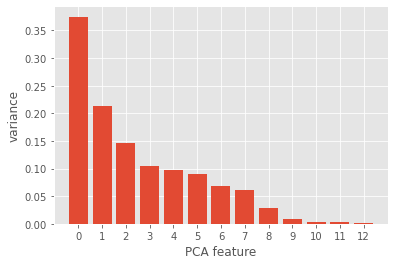

In [17]:
scaler = MinMaxScaler()
pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

### It looks like 7 dimentions is enaugh to represent our model
<p> Let`s build a new logistic regression model with reduced dimentions and compare its performance to the original one </p>

In [18]:
pca = PCA(n_components=7)
reduced_rescaled_X = pca.fit_transform(rescaledX)

reduced_grid_model = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5)
reduced_grid_model_result = reduced_grid_model.fit(reduced_rescaled_X, y)

best_score1, best_params1 = reduced_grid_model_result.best_score_, reduced_grid_model_result.best_params_
print("Best: %f using %s" % (best_score1, best_params1))

Best: 0.852174 using {&#39;max_iter&#39;: 100, &#39;penalty&#39;: &#39;l2&#39;, &#39;tol&#39;: 0.01}


### Lets again compare results by ploting the ROC courve and evaluating AUC

===========AUC============
reduced data optimized AUC: 0.8981255857544517
sliced data default AUC: 0.7050609184629804
full data optimized AUC: 0.7112933458294283


&lt;matplotlib.legend.Legend at 0x1ccb35c88e0&gt;

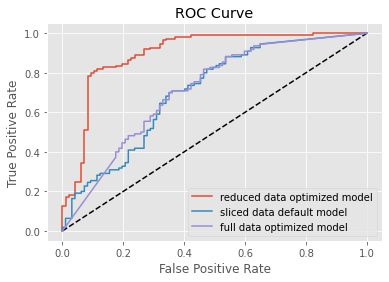

In [19]:
red_resc_Xtest = pca.transform(rescaledX_test)
reduced_data_model_y_prob1 = reduced_grid_model.predict_proba(red_resc_Xtest)[:,1]

reduced_fpr1, reduced_tpr1, _ = roc_curve(y_test, reduced_data_model_y_prob1)

print('===========AUC============')
print('reduced data optimized AUC:', roc_auc_score(y_test, reduced_data_model_y_prob1))
print('sliced data default AUC:', roc_auc_score(y_test, sliced_data_model_y_prob))
print('full data optimized AUC:', roc_auc_score(y_test, full_data_model_y_prob))
print('==========================')

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(reduced_fpr1, reduced_tpr1, label='reduced data optimized model')
plt.plot(sliced_fpr, sliced_tpr, label='sliced data default model')
plt.plot(full_fpr, full_tpr, label='full data optimized model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')